# 4. Using subdomain scheduling - (1+1)D Burgers' equation

This notebook shows you how to use subdomains scheduling to train a FBPINN.

# What is subdomain scheduling?

An advantage of using domain decomposition for FBPINNs is that we can control which **parts** of the domain are solved at each training step.

This is useful if we want to control how boundary conditions are **communicated** across the domain.

For example, we can define a **time-stepping scheduler** to solve time-dependent PDEs, and learn the solution forwards in time from a set of initial conditions (see gif below).

This is done by specifying a **subdomain scheduler** (from `fbpinns.schedulers`), which defines which subdomains are actively training and which subdomains have fixed parameters at each training step.

# Problem overview

In this example we will use a time-stepping subdomain scheduler to train a FBPINN to solve the (1+1)D time-dependent Burgers' equation:

<img src="../images/scheduling.gif" width="70%">

The exact partial differential equation (PDE) and boundary conditions we will solve for are:

$$
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} = \nu \dfrac{\partial^2 u}{\partial x^2}
$$

Where $u(x,t)$ is the speed of the fluid and $\nu$ defines the scalar viscosity of the flow.

This exact problem is already defined in the `fbpinns.problems.BurgersEquation2D` problem class.

# Workflow overview

We will use the following steps to define a scheduler and train the FBPINN:
1. Define a `fbpinns.schedulers.ActiveScheduler` class
2. Train the FBPINN using this `ActiveScheduler` class

## Step 1: Define a `fbpinns.schedulers.ActiveScheduler` class

### Inheriting the `ActiveScheduler` class

All scheduler classes should inherit from the base `fbpinns.schedulers.ActiveScheduler` class:

```python
class ActiveScheduler:
    """Base scheduler class to be inherited by different schedulers"""

    def __init__(self, all_params, n_steps):
        self.n_steps = n_steps
        self.m = all_params["static"]["decomposition"]["m"]
        self.xd = all_params["static"]["decomposition"]["xd"]

    def __len__(self):
        return self.n_steps

    def __iter__(self):
        """
        Returns None if active array not to be changed, otherwise active array.
        active is an array of length m, where each value corresponds
        to the state of each model (i.e. subdomain), which can be one of:

        0 = inactive (but still trained if it overlaps with active models)
        1 = active
        2 = fixed
        """

        raise NotImplementedError
```

`ActiveScheduler`s are simply **Python iterables** which output an `active` array, which is a flat vector which indicates which subdomains are active or fixed at each training step.

During training, the scheduler is iterated over and if the `active` array changes, the input training points to the FBPINN and the trained subdomains are changed appropriately.

The length of the active array should equal the number of subdomains in the FBPINN, which is stored in the `all_params["static"]["decomposition"]["m"]` parameter.

### Using a pre-defined `ActiveScheduler`

There are some pre-defined `ActiveScheduler`s in `fbpinns.schedulers`. In particular for the problem above we can use `fbinns.schedulers.LineSchedulerRectangularND` to time-step, which is appropriate for the `RectangularDecompositionND` class.

In this case all we need to do is define the initialisation values of the class:

```python
scheduler_kwargs = dict(
    point=[0.], iaxis=0,
)
```

which indicates the starting time of the scheduler ($t=0$) and the axis along which the line of active models is defined (the $x$-axis). 

## Step 2: Train the FBPINN using this `ActiveScheduler` class

Finally, we can train a `FBPINN` using this `ActiveScheduler` class:

[INFO] 2025-03-25 23:53:25 - <fbpinns.constants.Constants object at 0x7f6af32df410>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-1.,  0.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.BurgersEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.30526316, 0.30526316, 0.30526316, 0.30526316, 0.30526316,
       0.30526316, 0.30526316, 0.30526316, 0.30526316, 0.30526316,
   

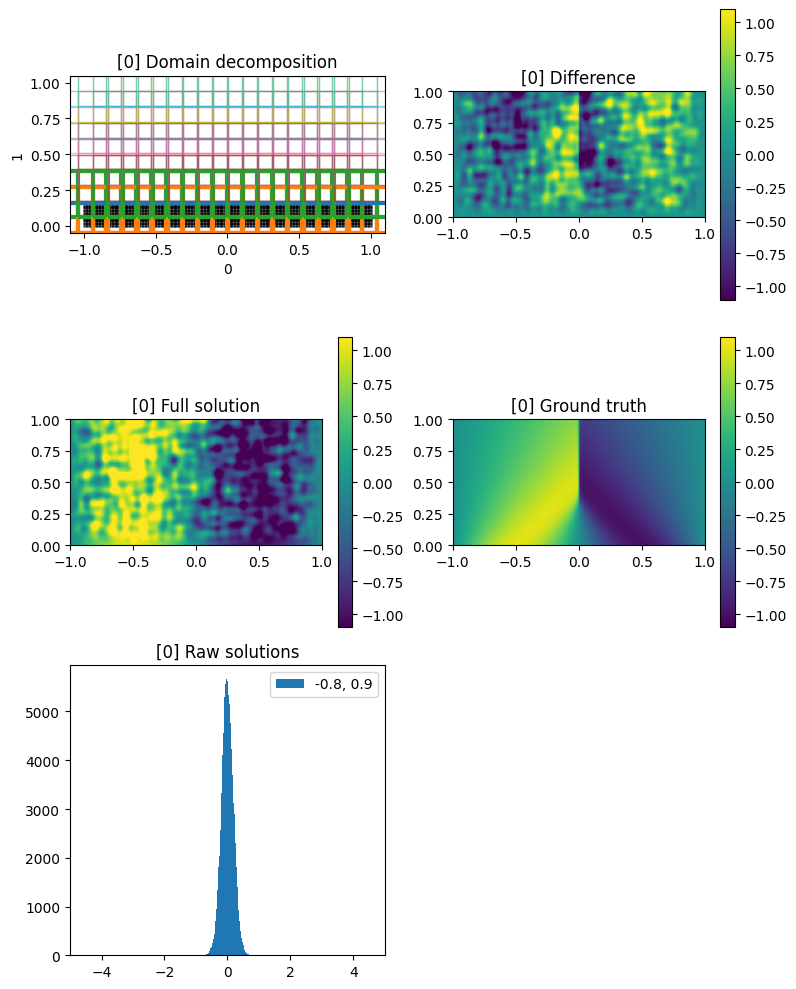

[INFO] 2025-03-25 23:53:36 - [i: 1000/100000] loss: 0.0047 rate: 270.5 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:37 - [i: 2000/100000] loss: 0.0010 rate: 3006.8 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:37 - [i: 3000/100000] loss: 0.0004 rate: 2876.4 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:37 - [i: 4000/100000] loss: 0.0002 rate: 2877.1 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:38 - [i: 5000/100000] loss: 0.0002 rate: 2841.4 elapsed: 0.00 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


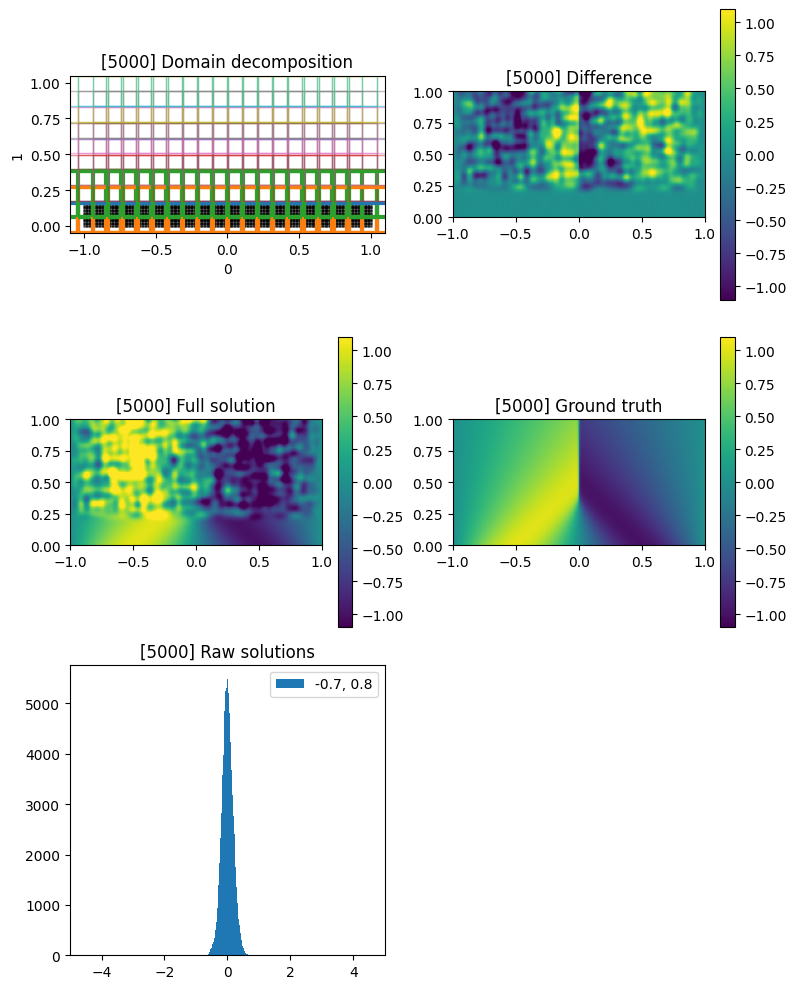

[INFO] 2025-03-25 23:53:38 - [i: 5264/100000] Updating active inputs..
[INFO] 2025-03-25 23:53:38 - [i: 5264/100000] Average number of points/dimension in active subdomains: 27.74
[INFO] 2025-03-25 23:53:40 - [i: 5264/100000] Updating active inputs done (1.76 s)
[INFO] 2025-03-25 23:53:40 - [i: 5264/100000] Compiling update step..
[INFO] 2025-03-25 23:53:40 - x_batch
[INFO] 2025-03-25 23:53:40 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-25 23:53:40 - x_take
[INFO] 2025-03-25 23:53:40 - (41040, 2), float32, JVPTracer
input: (2,)
output: (1,)
[INFO] 2025-03-25 23:53:40 - x_batch
[INFO] 2025-03-25 23:53:40 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-25 23:53:40 - x_take
[INFO] 2025-03-25 23:53:40 - (41040, 2), float32, JVPTracer
input: (2,)
output: (1,)
[INFO] 2025-03-25 23:53:42 - [i: 5264/100000] Compiling done (1.58 s)
[INFO] 2025-03-25 23:53:42 - [i: 6000/100000] loss: 0.0018 rate: 261.2 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:42 - [i: 7000/100000] loss: 0.0007 rate: 1904.

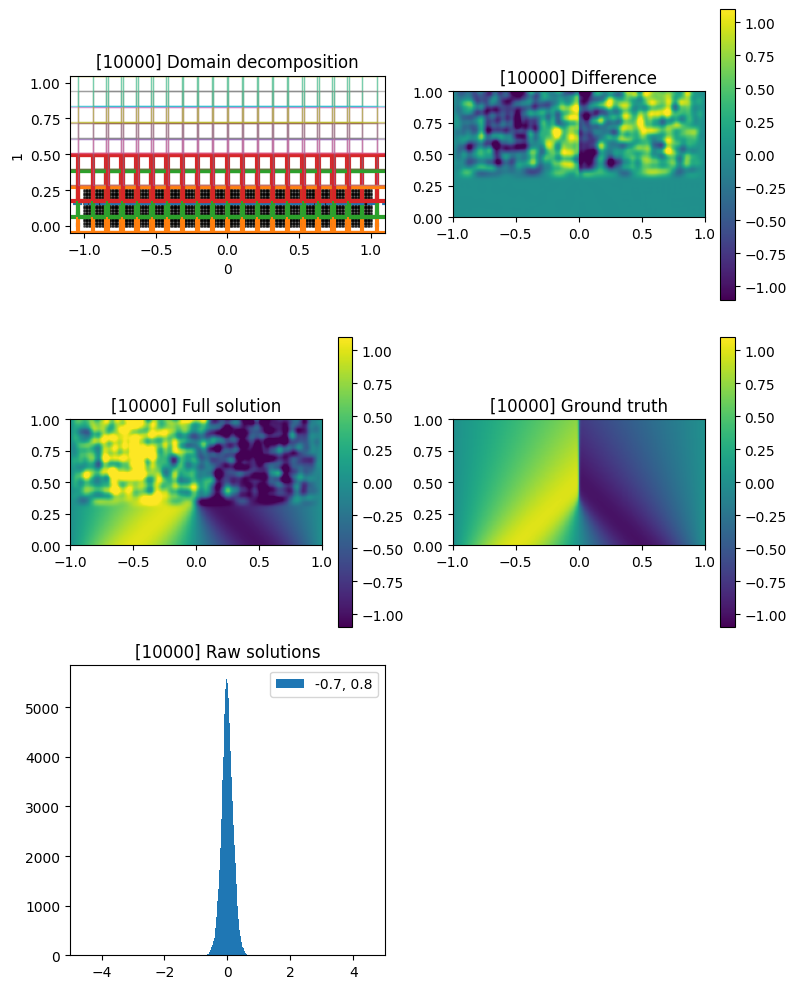

[INFO] 2025-03-25 23:53:45 - [i: 11000/100000] loss: 0.0004 rate: 1913.5 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:46 - [i: 12000/100000] loss: 0.0004 rate: 1913.5 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:46 - [i: 13000/100000] loss: 0.0004 rate: 1920.6 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:47 - [i: 14000/100000] loss: 0.0007 rate: 1915.4 elapsed: 0.00 hr test
[INFO] 2025-03-25 23:53:47 - [i: 15000/100000] loss: 0.0006 rate: 1916.7 elapsed: 0.00 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


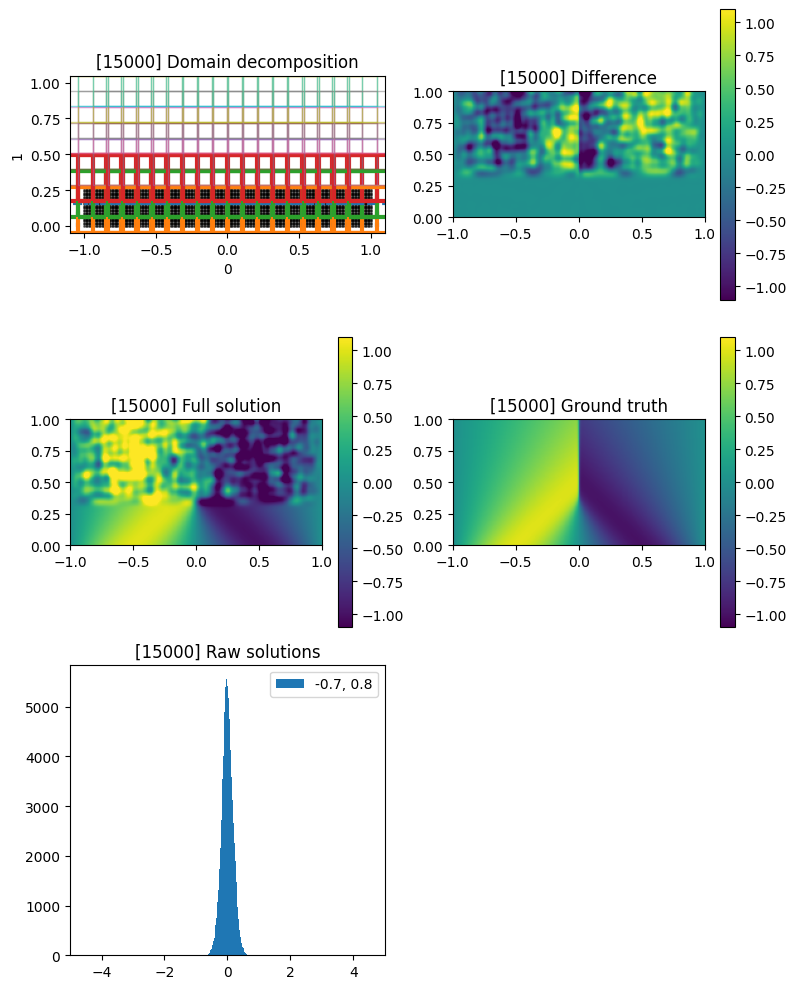

[INFO] 2025-03-25 23:53:48 - [i: 15790/100000] Updating active inputs..
[INFO] 2025-03-25 23:53:48 - [i: 15790/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-25 23:53:50 - [i: 15790/100000] Updating active inputs done (1.85 s)
[INFO] 2025-03-25 23:53:50 - [i: 15790/100000] Compiling update step..
[INFO] 2025-03-25 23:53:50 - x_batch
[INFO] 2025-03-25 23:53:50 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-25 23:53:50 - x_take
[INFO] 2025-03-25 23:53:50 - (50730, 2), float32, JVPTracer
input: (2,)
output: (1,)
[INFO] 2025-03-25 23:53:50 - x_batch
[INFO] 2025-03-25 23:53:50 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-25 23:53:50 - x_take
[INFO] 2025-03-25 23:53:50 - (50730, 2), float32, JVPTracer
input: (2,)
output: (1,)
[INFO] 2025-03-25 23:53:52 - [i: 15790/100000] Compiling done (1.61 s)
[INFO] 2025-03-25 23:53:52 - [i: 16000/100000] loss: 0.0441 rate: 249.5 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:53:52 - [i: 17000/100000] loss: 0.0344 rate

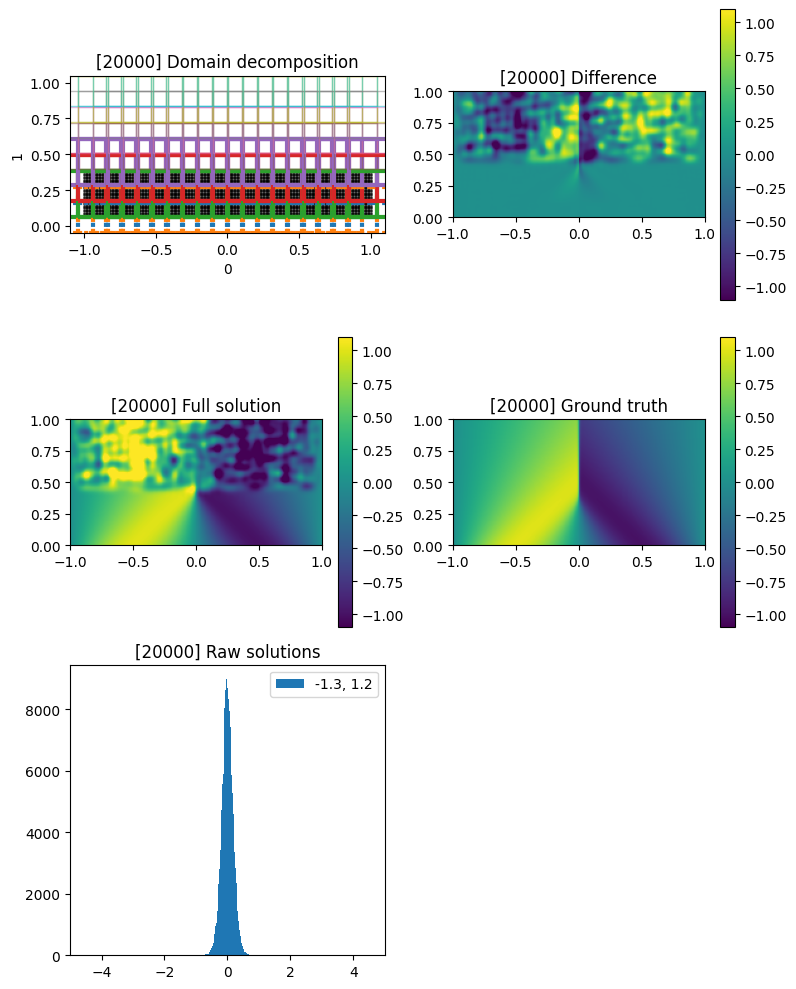

[INFO] 2025-03-25 23:53:56 - [i: 21000/100000] loss: 0.0319 rate: 1496.6 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:53:56 - [i: 22000/100000] loss: 0.0322 rate: 1472.7 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:53:57 - [i: 23000/100000] loss: 0.0316 rate: 1485.5 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:53:58 - [i: 24000/100000] loss: 0.0314 rate: 1480.5 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:53:58 - [i: 25000/100000] loss: 0.0312 rate: 1483.1 elapsed: 0.01 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


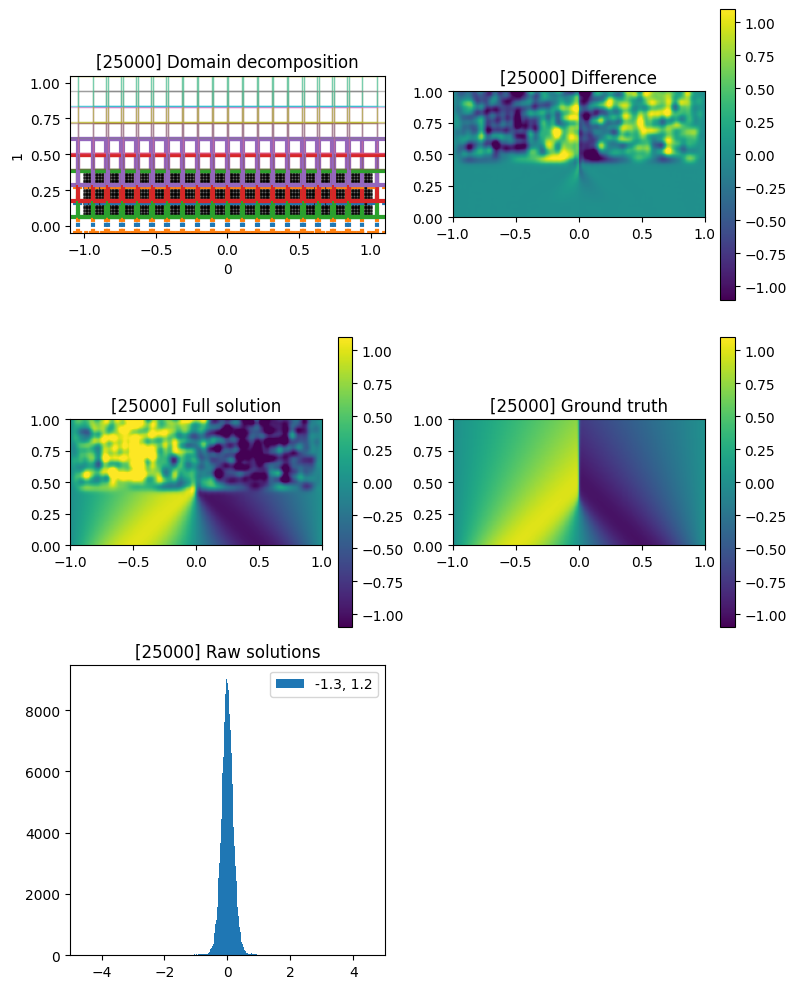

[INFO] 2025-03-25 23:54:00 - [i: 26000/100000] loss: 0.0315 rate: 1483.9 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:00 - [i: 26316/100000] Updating active inputs..
[INFO] 2025-03-25 23:54:00 - [i: 26316/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-25 23:54:00 - [i: 26316/100000] Updating active inputs done (0.17 s)
[INFO] 2025-03-25 23:54:00 - [i: 26316/100000] Compiling update step..
[INFO] 2025-03-25 23:54:00 - [i: 26316/100000] Compiling done (0.02 s)
[INFO] 2025-03-25 23:54:00 - [i: 27000/100000] loss: 0.2393 rate: 1159.0 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:01 - [i: 28000/100000] loss: 0.2293 rate: 1495.7 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:02 - [i: 29000/100000] loss: 0.2262 rate: 1485.8 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:03 - [i: 30000/100000] loss: 0.2251 rate: 1485.5 elapsed: 0.01 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


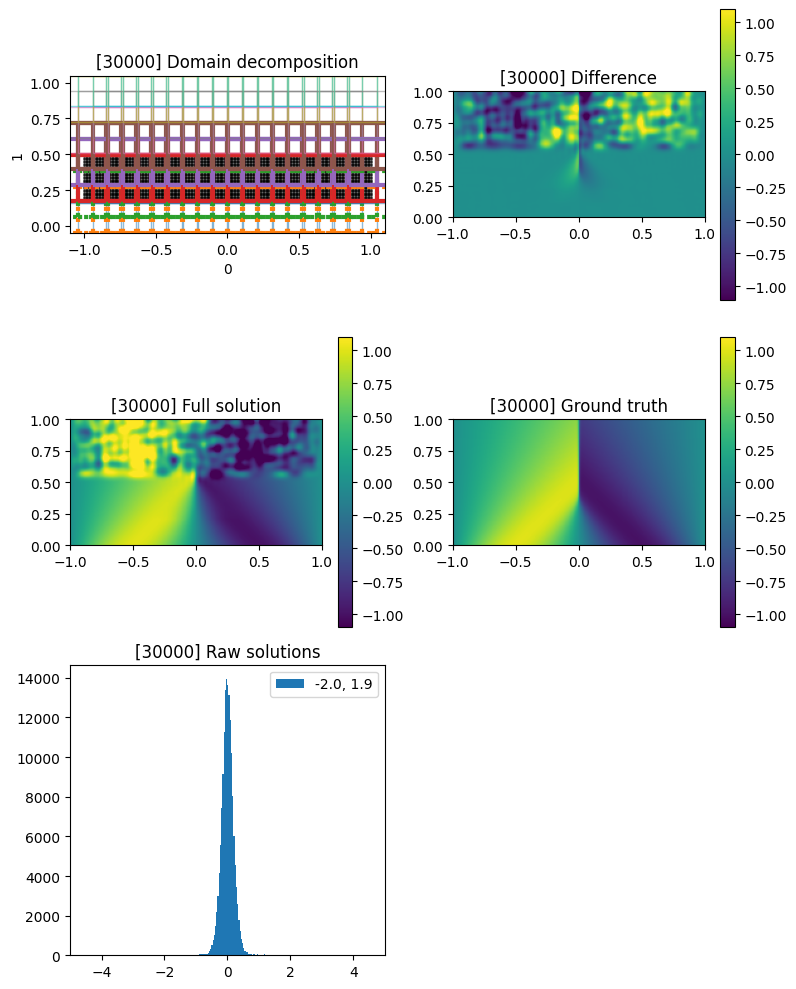

[INFO] 2025-03-25 23:54:04 - [i: 31000/100000] loss: 0.2241 rate: 1495.6 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:04 - [i: 32000/100000] loss: 0.2234 rate: 1494.7 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:05 - [i: 33000/100000] loss: 0.2228 rate: 1495.4 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:06 - [i: 34000/100000] loss: 0.2213 rate: 1496.1 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:06 - [i: 35000/100000] loss: 0.2207 rate: 1501.4 elapsed: 0.01 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


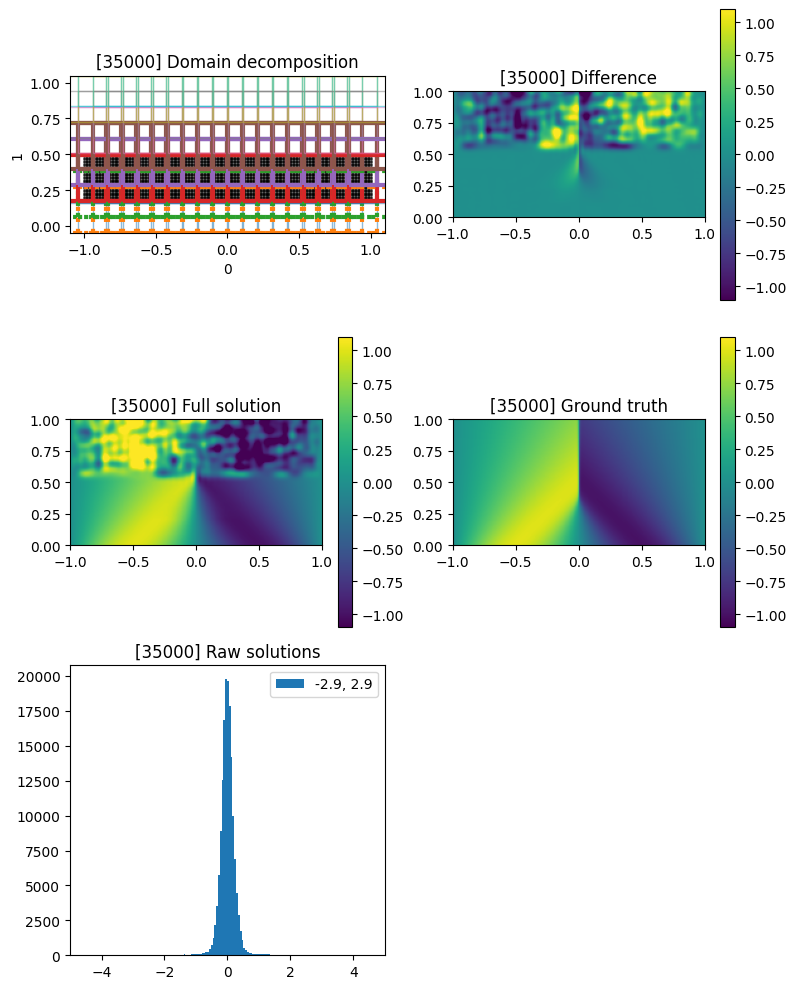

[INFO] 2025-03-25 23:54:08 - [i: 36000/100000] loss: 0.2203 rate: 1508.8 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:08 - [i: 36843/100000] Updating active inputs..
[INFO] 2025-03-25 23:54:08 - [i: 36843/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-25 23:54:08 - [i: 36843/100000] Updating active inputs done (0.04 s)
[INFO] 2025-03-25 23:54:08 - [i: 36843/100000] Compiling update step..
[INFO] 2025-03-25 23:54:08 - [i: 36843/100000] Compiling done (0.03 s)
[INFO] 2025-03-25 23:54:09 - [i: 37000/100000] loss: 0.4526 rate: 1373.4 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:09 - [i: 38000/100000] loss: 0.3953 rate: 1512.2 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:10 - [i: 39000/100000] loss: 0.3901 rate: 1516.7 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:11 - [i: 40000/100000] loss: 0.3876 rate: 1513.2 elapsed: 0.01 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


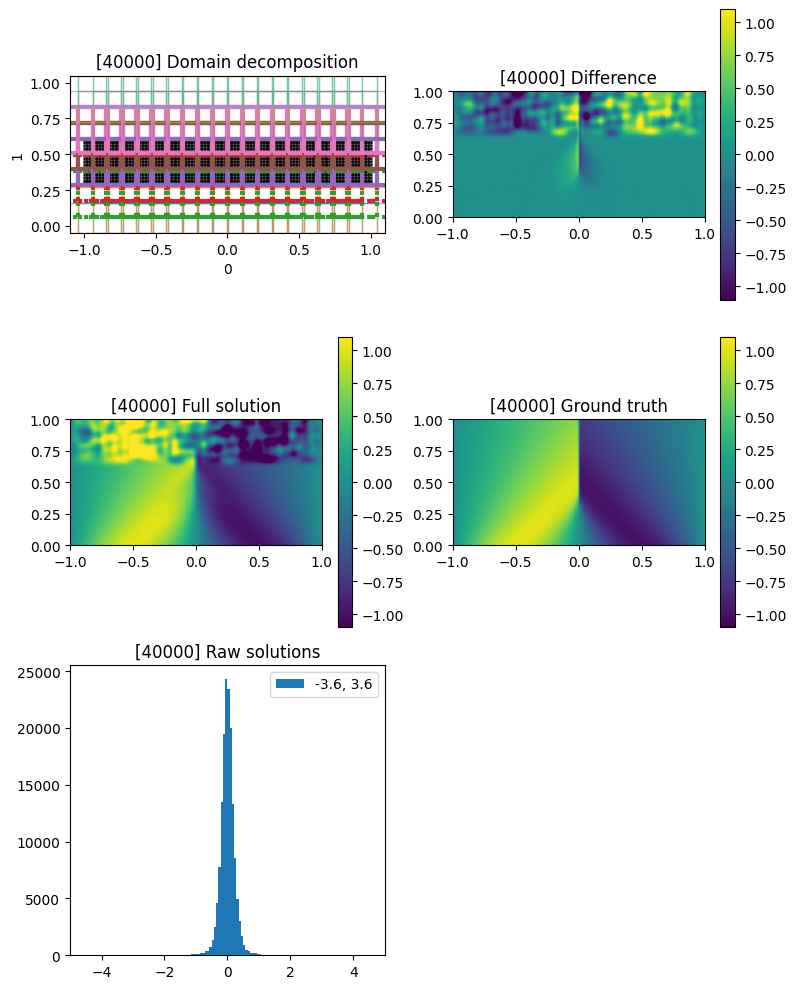

[INFO] 2025-03-25 23:54:12 - [i: 41000/100000] loss: 0.3859 rate: 1507.0 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:12 - [i: 42000/100000] loss: 0.3845 rate: 1515.6 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:13 - [i: 43000/100000] loss: 0.3828 rate: 1515.1 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:14 - [i: 44000/100000] loss: 0.3814 rate: 1517.0 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:14 - [i: 45000/100000] loss: 0.3799 rate: 1517.8 elapsed: 0.01 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


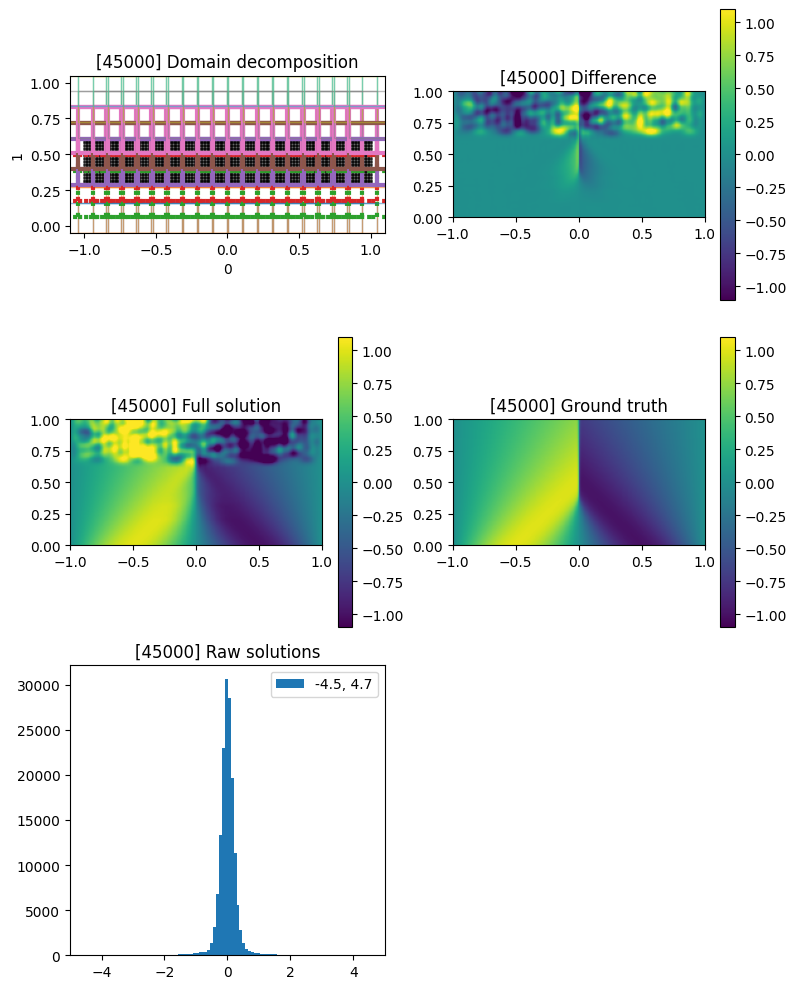

[INFO] 2025-03-25 23:54:16 - [i: 46000/100000] loss: 0.3785 rate: 1520.0 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:16 - [i: 47000/100000] loss: 0.3774 rate: 1514.9 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:16 - [i: 47369/100000] Updating active inputs..
[INFO] 2025-03-25 23:54:16 - [i: 47369/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-25 23:54:17 - [i: 47369/100000] Updating active inputs done (0.03 s)
[INFO] 2025-03-25 23:54:17 - [i: 47369/100000] Compiling update step..
[INFO] 2025-03-25 23:54:17 - [i: 47369/100000] Compiling done (0.02 s)
[INFO] 2025-03-25 23:54:17 - [i: 48000/100000] loss: 0.4440 rate: 1396.5 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:18 - [i: 49000/100000] loss: 0.4288 rate: 1515.2 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:18 - [i: 50000/100000] loss: 0.4247 rate: 1504.8 elapsed: 0.01 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


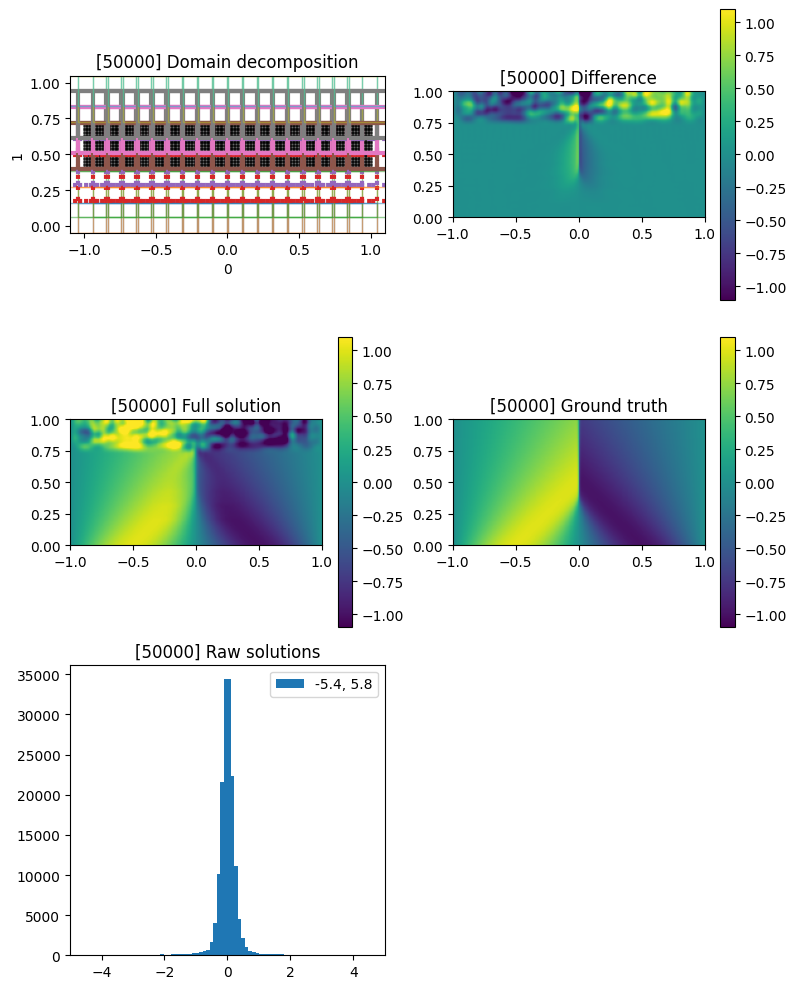

[INFO] 2025-03-25 23:54:19 - [i: 51000/100000] loss: 0.4225 rate: 1500.4 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:20 - [i: 52000/100000] loss: 0.4204 rate: 1501.9 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:21 - [i: 53000/100000] loss: 0.4185 rate: 1497.6 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:22 - [i: 54000/100000] loss: 0.4167 rate: 1501.6 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:22 - [i: 55000/100000] loss: 0.4162 rate: 1498.3 elapsed: 0.01 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


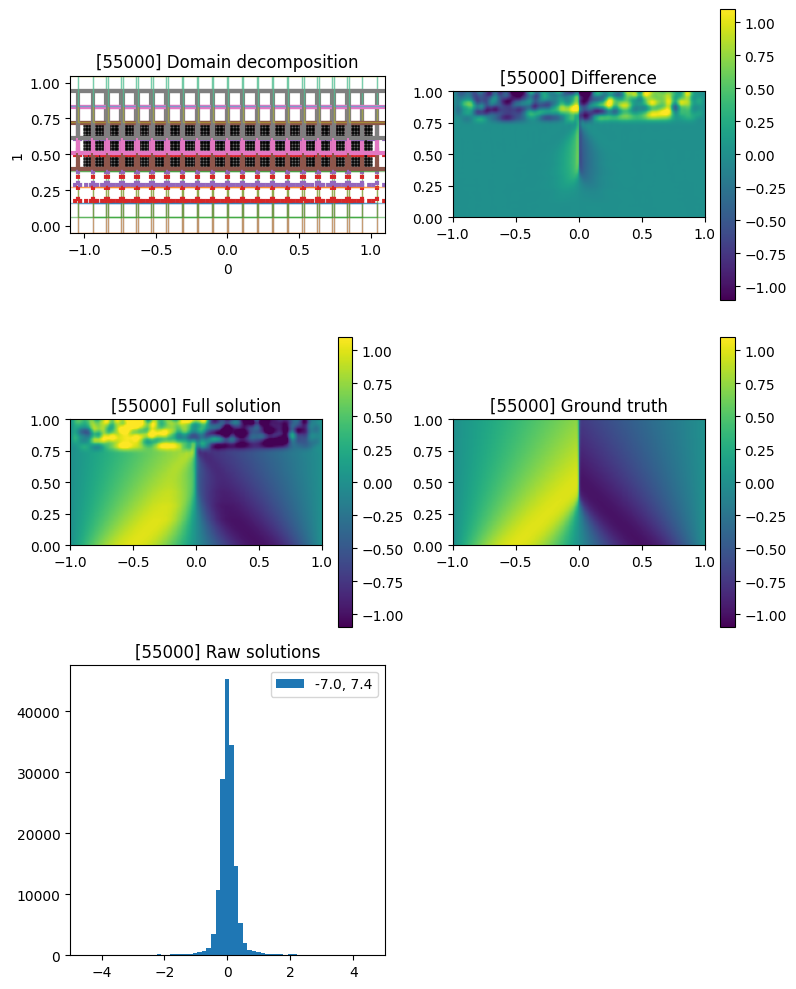

[INFO] 2025-03-25 23:54:23 - [i: 56000/100000] loss: 0.4133 rate: 1502.4 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:24 - [i: 57000/100000] loss: 0.4130 rate: 1514.2 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:25 - [i: 57895/100000] Updating active inputs..
[INFO] 2025-03-25 23:54:25 - [i: 57895/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-25 23:54:25 - [i: 57895/100000] Updating active inputs done (0.05 s)
[INFO] 2025-03-25 23:54:25 - [i: 57895/100000] Compiling update step..
[INFO] 2025-03-25 23:54:25 - [i: 57895/100000] Compiling done (0.03 s)
[INFO] 2025-03-25 23:54:25 - [i: 58000/100000] loss: 0.4180 rate: 1359.4 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:26 - [i: 59000/100000] loss: 0.3664 rate: 1508.9 elapsed: 0.01 hr test
[INFO] 2025-03-25 23:54:26 - [i: 60000/100000] loss: 0.3630 rate: 1513.0 elapsed: 0.02 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


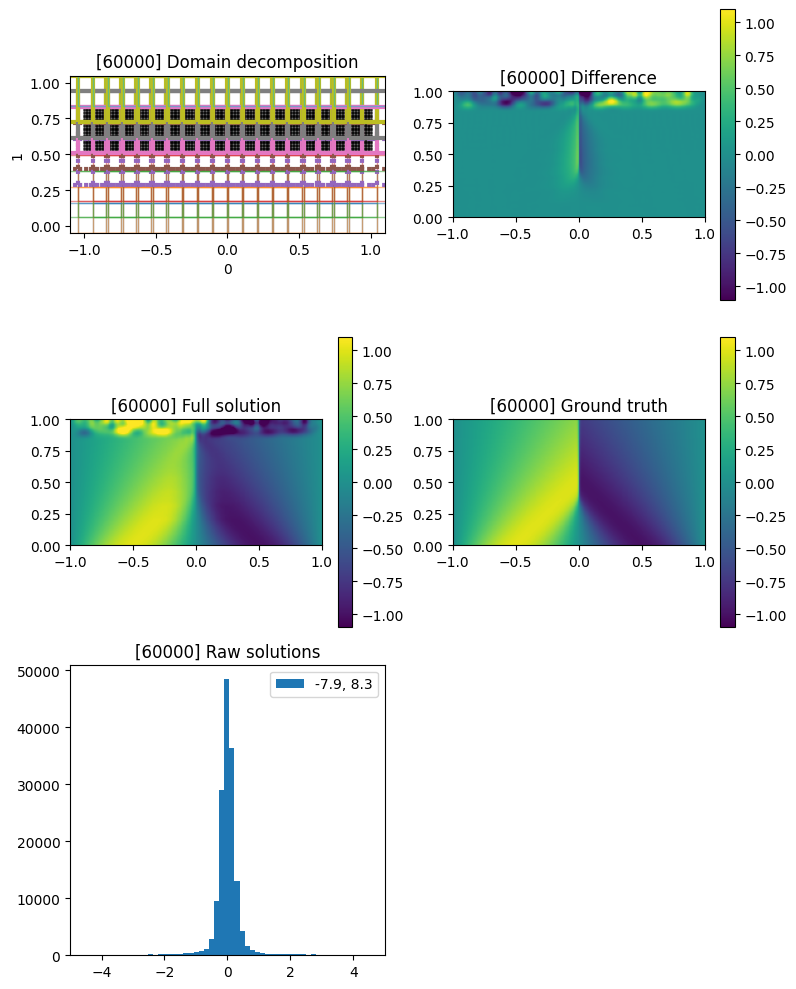

[INFO] 2025-03-25 23:54:27 - [i: 61000/100000] loss: 0.3612 rate: 1517.0 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:28 - [i: 62000/100000] loss: 0.3597 rate: 1513.2 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:29 - [i: 63000/100000] loss: 0.3582 rate: 1512.1 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:29 - [i: 64000/100000] loss: 0.3568 rate: 1516.6 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:30 - [i: 65000/100000] loss: 0.3551 rate: 1515.9 elapsed: 0.02 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


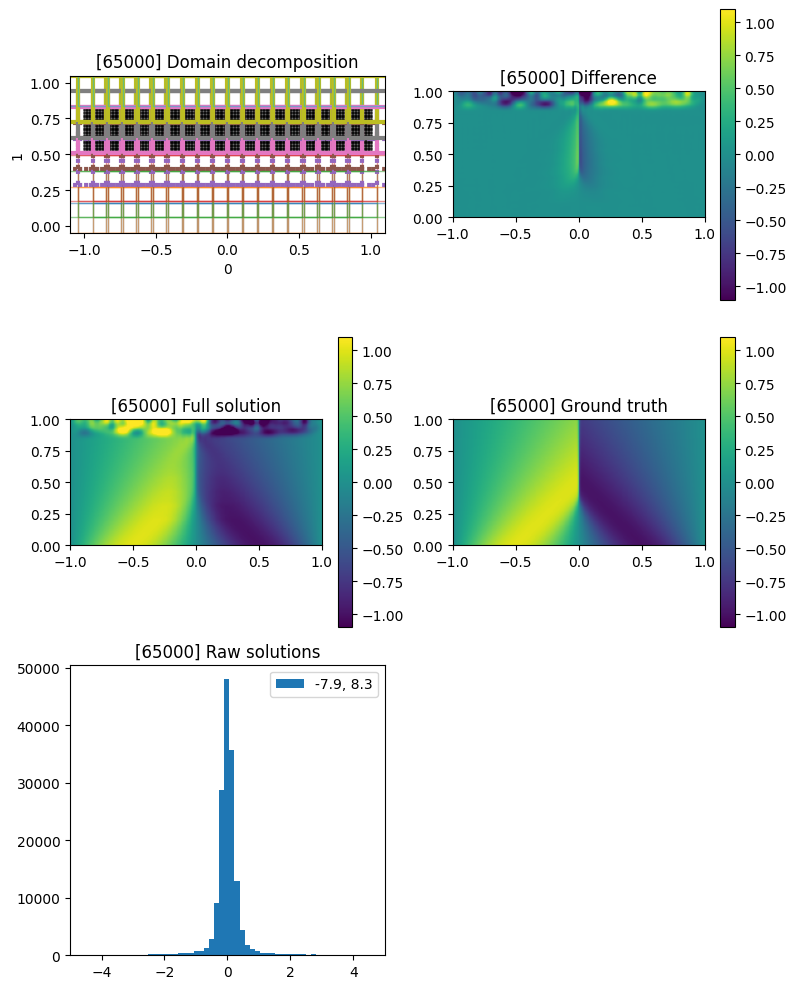

[INFO] 2025-03-25 23:54:31 - [i: 66000/100000] loss: 0.3534 rate: 1516.2 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:32 - [i: 67000/100000] loss: 0.3518 rate: 1517.2 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:33 - [i: 68000/100000] loss: 0.3505 rate: 1512.4 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:33 - [i: 68422/100000] Updating active inputs..
[INFO] 2025-03-25 23:54:33 - [i: 68422/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-25 23:54:33 - [i: 68422/100000] Updating active inputs done (0.10 s)
[INFO] 2025-03-25 23:54:33 - [i: 68422/100000] Compiling update step..
[INFO] 2025-03-25 23:54:33 - [i: 68422/100000] Compiling done (0.03 s)
[INFO] 2025-03-25 23:54:33 - [i: 69000/100000] loss: 0.2888 rate: 1268.0 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:34 - [i: 70000/100000] loss: 0.2807 rate: 1513.8 elapsed: 0.02 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


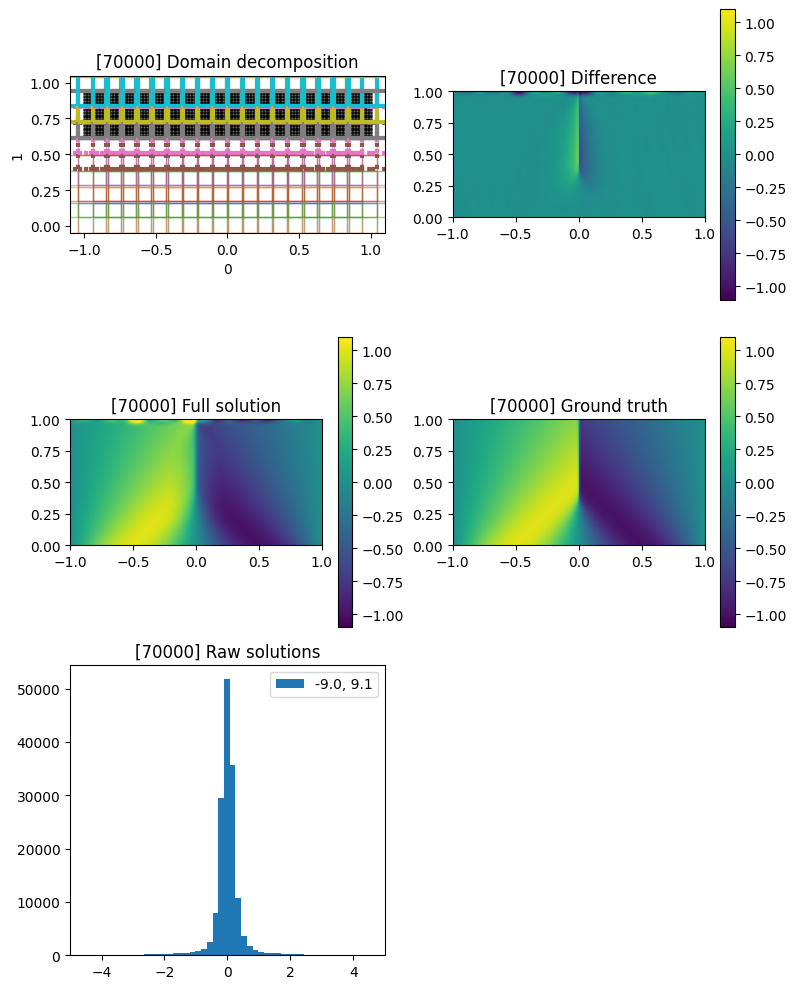

[INFO] 2025-03-25 23:54:35 - [i: 71000/100000] loss: 0.2785 rate: 1506.5 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:36 - [i: 72000/100000] loss: 0.2772 rate: 1506.9 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:37 - [i: 73000/100000] loss: 0.2760 rate: 1507.8 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:37 - [i: 74000/100000] loss: 0.2747 rate: 1510.0 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:38 - [i: 75000/100000] loss: 0.2733 rate: 1511.2 elapsed: 0.02 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


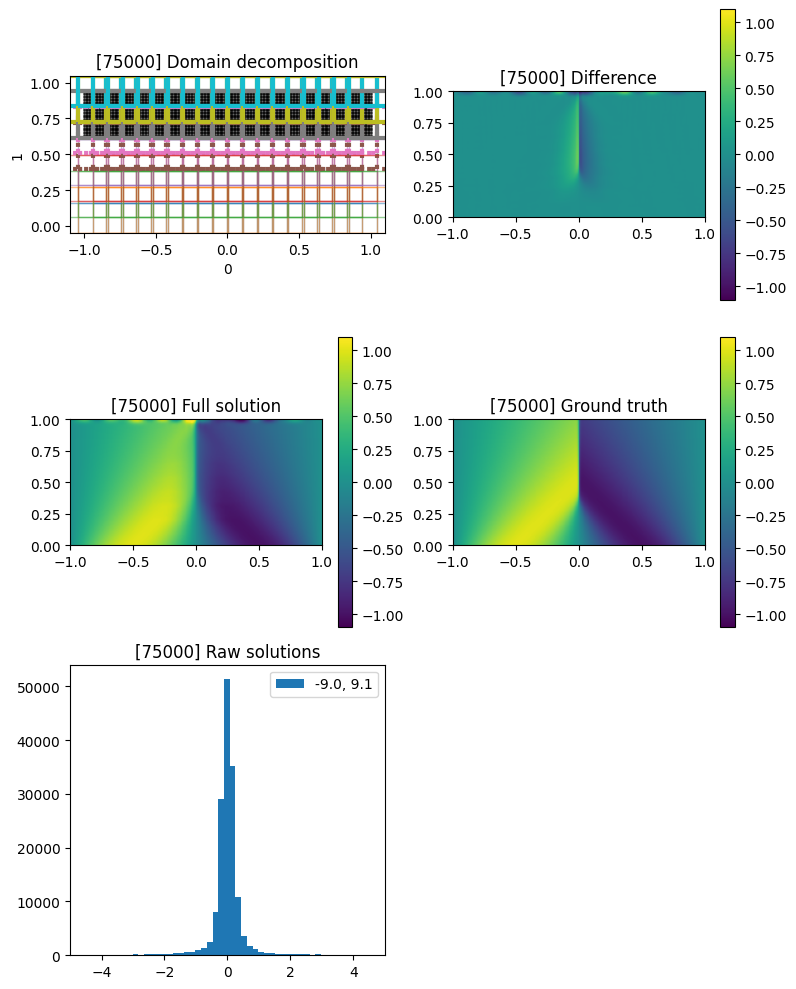

[INFO] 2025-03-25 23:54:39 - [i: 76000/100000] loss: 0.2718 rate: 1513.6 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:40 - [i: 77000/100000] loss: 0.2705 rate: 1516.2 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:40 - [i: 78000/100000] loss: 0.2689 rate: 1515.7 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:41 - [i: 78948/100000] Updating active inputs..
[INFO] 2025-03-25 23:54:41 - [i: 78948/100000] Average number of points/dimension in active subdomains: 27.74
[INFO] 2025-03-25 23:54:41 - [i: 78948/100000] Updating active inputs done (0.10 s)
[INFO] 2025-03-25 23:54:41 - [i: 78948/100000] Compiling update step..
[INFO] 2025-03-25 23:54:41 - x_batch
[INFO] 2025-03-25 23:54:41 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-25 23:54:41 - x_take
[INFO] 2025-03-25 23:54:41 - (41040, 2), float32, JVPTracer
input: (2,)
output: (1,)
[INFO] 2025-03-25 23:54:41 - x_batch
[INFO] 2025-03-25 23:54:41 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-25 23:54:41 - x_take
[INFO] 2025-03-25 23:54:41 - 

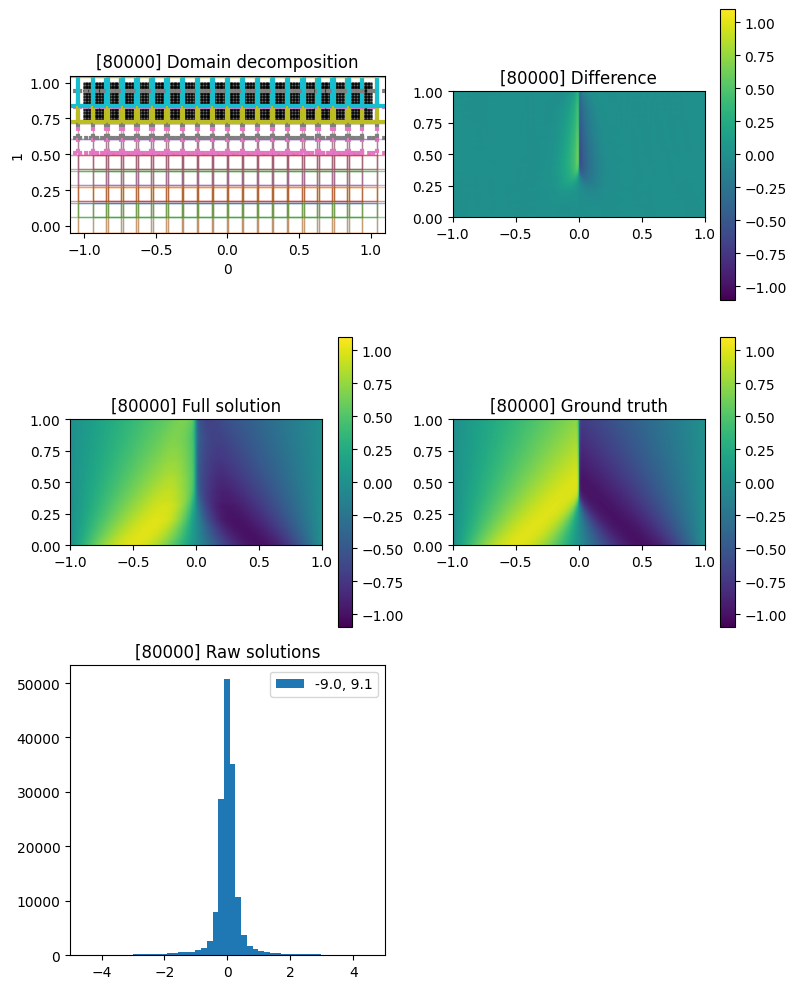

[INFO] 2025-03-25 23:54:44 - [i: 81000/100000] loss: 0.2153 rate: 1939.1 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:45 - [i: 82000/100000] loss: 0.2146 rate: 1940.5 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:45 - [i: 83000/100000] loss: 0.2136 rate: 1946.2 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:46 - [i: 84000/100000] loss: 0.2124 rate: 1944.0 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:46 - [i: 85000/100000] loss: 0.2111 rate: 2061.2 elapsed: 0.02 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


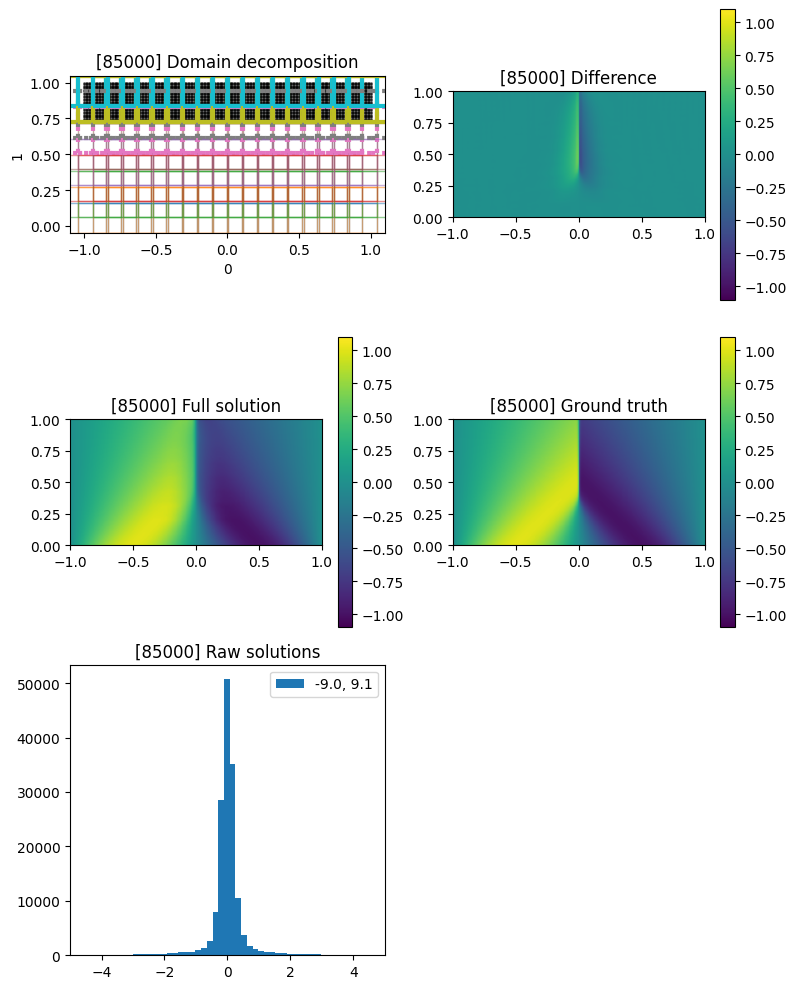

[INFO] 2025-03-25 23:54:47 - [i: 86000/100000] loss: 0.2097 rate: 2113.9 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:48 - [i: 87000/100000] loss: 0.2084 rate: 2087.5 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:48 - [i: 88000/100000] loss: 0.2071 rate: 1979.1 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:49 - [i: 89000/100000] loss: 0.2059 rate: 2025.1 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:49 - [i: 89474/100000] Updating active inputs..
[INFO] 2025-03-25 23:54:49 - [i: 89474/100000] Average number of points/dimension in active subdomains: 21.35
[INFO] 2025-03-25 23:54:49 - [i: 89474/100000] Updating active inputs done (0.07 s)
[INFO] 2025-03-25 23:54:49 - [i: 89474/100000] Compiling update step..
[INFO] 2025-03-25 23:54:49 - x_batch
[INFO] 2025-03-25 23:54:49 - (3200, 2), float32, JVPTracer
[INFO] 2025-03-25 23:54:49 - x_take
[INFO] 2025-03-25 23:54:49 - (23370, 2), float32, JVPTracer
input: (2,)
output: (1,)
[INFO] 2025-03-25 23:54:49 - x_batch
[INFO] 2025-03-25 23:54:49 - 

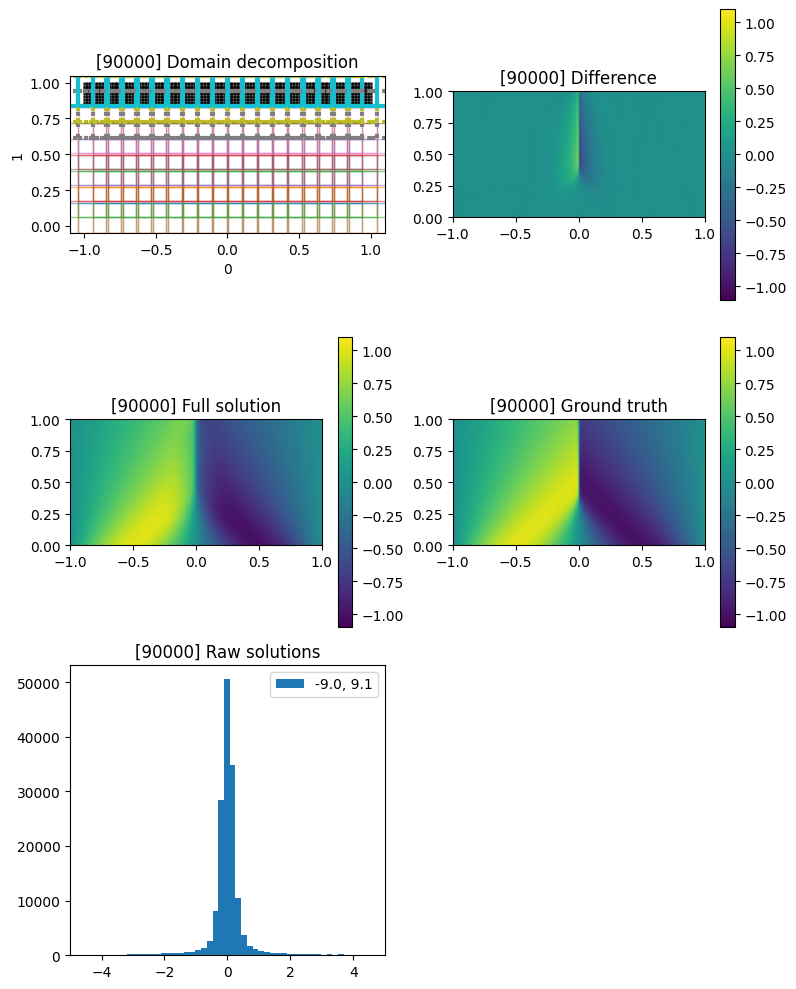

[INFO] 2025-03-25 23:54:52 - [i: 91000/100000] loss: 0.1511 rate: 3255.3 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:52 - [i: 92000/100000] loss: 0.1492 rate: 3257.8 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:52 - [i: 93000/100000] loss: 0.1477 rate: 3241.3 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:53 - [i: 94000/100000] loss: 0.1461 rate: 3218.9 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:53 - [i: 95000/100000] loss: 0.1447 rate: 3238.2 elapsed: 0.02 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


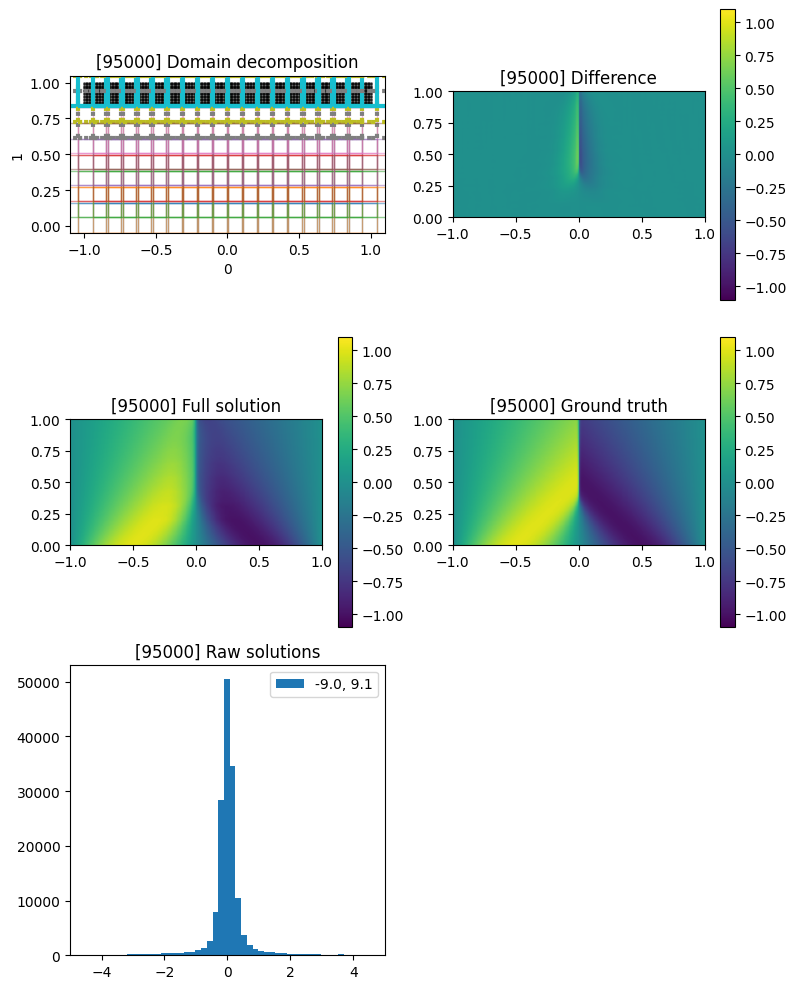

[INFO] 2025-03-25 23:54:54 - [i: 96000/100000] loss: 0.1433 rate: 3242.2 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:54 - [i: 97000/100000] loss: 0.1420 rate: 3255.9 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:54 - [i: 98000/100000] loss: 0.1408 rate: 3214.1 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:55 - [i: 99000/100000] loss: 0.1396 rate: 3223.9 elapsed: 0.02 hr test
[INFO] 2025-03-25 23:54:55 - [i: 100000/100000] loss: 0.1385 rate: 3253.0 elapsed: 0.02 hr test
fs (('test', <Figure size 800x1000 with 8 Axes>),)
True


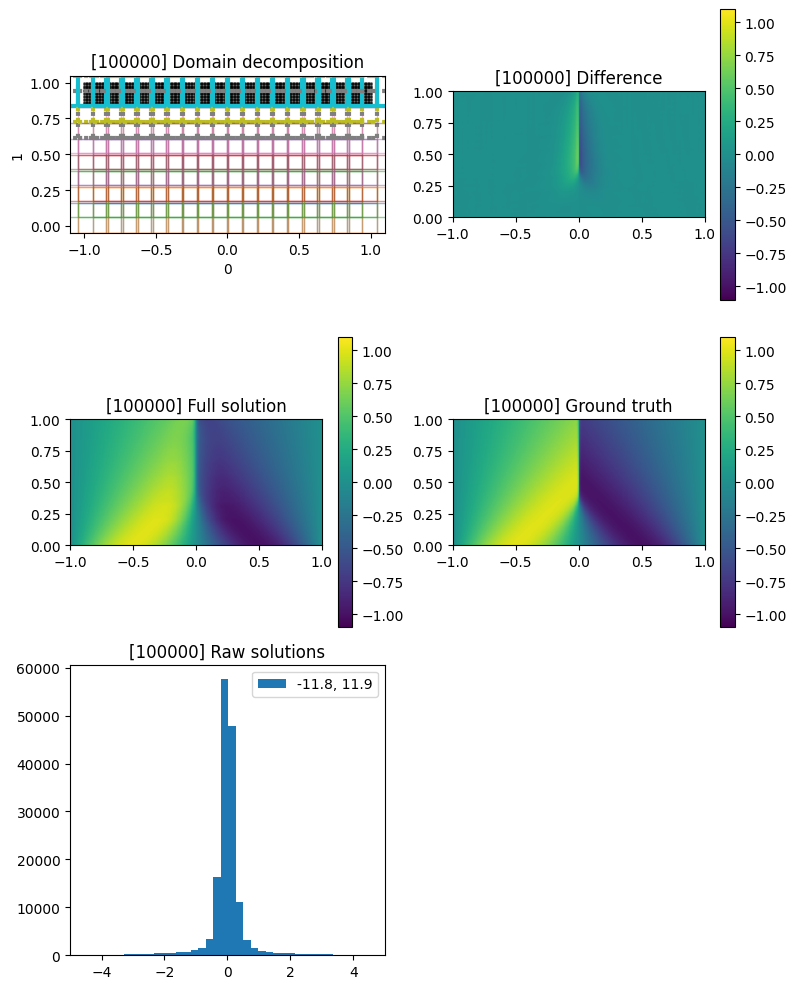

[INFO] 2025-03-25 23:54:55 - [i: 100000/100000] Training complete


In [1]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

subdomain_xs=[np.linspace(-1,1,20), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([-1,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=BurgersEquation2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 1),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=9
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    ns=((200,100),),
    n_test=(200,100),
    n_steps=100000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()